## A/B Test Results Analysis

### Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)

<a id='intro'></a>
### Introduction
In this project, I'll be analysing the results from an A/B test for a company's e-commerce website, working to understand those results, and proffer helpful suggestions. The company has developed a new web page in order to try and increase the number of users who "convert" (i.e. the number of users who decide to pay for the company's product). The goal here is to help the company decide whether to implement the new page, keep the old page, or perhaps run the experiment longer before making a decision.

#### Info on datasets
1. **`ab_data.csv` dataset**

This dataset contains information about the `200K+` users involved in the A/B test.
* `user_id` - unique identifier for each user
* `timestamp` - associated date and time for each visit to the website by a given user
* `group` - the category a user was grouped into pre-A/B test (`control` or `treatment` groups)
* `landing_page` - the page that was displayed to a user when they visited the company website (`new_page` or `old_page`)
* `converted` - whether a user converted or not (`0` or `1`)
**NB:** Users in the control group ought to be displayed the old page, while those in the treatment group ought to see the new page.

<a id='probability'></a>
#### Part I - Probability

Import relevant libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

#I am setting a random seed to ensure reproducibility of results
random.seed(42)

Load in the `ab_data.csv` dataset and take a look at the top few rows.

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


Check for inconvenient data types and missing values

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


The `timestamp` column is an `object` type, a `datetime` tyope would be more appropriate.

There are no missing values.

In [4]:
# convert 'timestamp' to datetime for easier manipulation
df.timestamp = pd.to_datetime(df.timestamp)

In [5]:
# confirm that worked
df.dtypes

user_id                  int64
timestamp       datetime64[ns]
group                   object
landing_page            object
converted                int64
dtype: object

Now let's get some preliminary stats about the results presented in the dataset.

First, let's see the number of visits that were made to the website.

In [6]:
print('The website was visited', df.shape[0], 'times.')

The website was visited 294478 times.


Then the number of unique users in the dataset.

In [7]:
print('There are', df.user_id.nunique(), 'unique users.')

There are 290584 unique users.


For how long was the test conducted?

In [41]:
print('The A/B test was conducted for', len(df.timestamp.dt.floor('d').value_counts()), 'days.')

The A/B test was conducted for 23 days.


Now I'll check what proportion of users converted

In [9]:
df[df.converted == 1].shape[0]/df.shape[0]

0.11965919355605512

Approximately 12% of the visits to the website resulted in conversions.

### Analysis of results

Our A/B test is contigent on all members of the control group having viewed the old page, and those in the treatment group having viewed the new page. Hence, we must ensure that this is the case in our dataset, and get rid of any entries that do not satisfy this criterion for whatever reason (could be due to the mismatching of group members to their corresponding pages, or simply an error occurred during data gathering).

Firstly, I'll check the number of times the `new_page` and `treatment` don't line up. Hopefully it isn't the majority of the dataset.

In [10]:
df[((df.group=='treatment') & (df.landing_page!='new_page')) | 
   ((df.group!='treatment') & (df.landing_page=='new_page'))].shape[0]
# OR
# df[((df['group'] == 'treatment') ^ (df['landing_page'] == 'new_page'))].shape[0]
# OR
# df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == False].shape[0]

3893

Not very many compared to the total entries in the dataset.

Now, for the rows where `treatment` is not aligned with `new_page` or `control` is not aligned with `old_page`, we cannot be sure if this row truly received the new or old page. So we drop all the rows that don't meet the specifications.
I assign the result to a new dataframe variable.

In [11]:
# Make use of exclusive OR (XOR) to find disalignment between page and corresponding group
df2 = df.drop(df[((df['group'] == 'treatment') ^ (df['landing_page'] == 'new_page'))].index, axis=0)

In [12]:
# Double Check all of the correct rows were removed - this should return 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

Next, I want to ensure that the new dataset does not contain repeated entries for a given user, in order to avoid misleading results.

Compare number of unique ids to total number of rows in df2

In [13]:
df2.user_id.nunique()

290584

In [14]:
df2.user_id.shape

(290585,)

There appears to be one duplicate row

In [15]:
df2[df2.user_id.duplicated(keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [16]:
# drop the first duplicate with index 1899
df2.drop([1899], inplace=True)

### Some essential probabilities

Next, I am going to find the probability of an individual converting regardless of the page they received?

In [17]:
df2.converted.sum()/df2.shape[0]

0.11959708724499628

This value is pretty close to the one we got from the previous unfiltered dataset: approximately `12%`.

Now I want to find the conversion rate or probability of conversion, given that an individual was in the `control` group, and also given that an individual was in the `treatment` grouup.

In [18]:
# control group conversion rate
ctrl = df2[df2.group=='control']
p_ctrl = ctrl.converted.sum()/ctrl.shape[0]
p_ctrl

0.1203863045004612

In [19]:
# treatment group conversion rate
treat = df2[df2.group=='treatment']
p_treat = treat.converted.sum()/treat.shape[0]
p_treat

0.11880806551510564

We seem to be getting quite similar values in all cases: roughly `12%`.

So, let's see the probability that an individual actually received the new page.

In [20]:
(df2.landing_page=='new_page').sum()/df2.shape[0]

0.5000619442226688

As we would expect, an individual receives the new page half of the time, which might be why the conversion rates for both pages are quite similar.

From the calculations of the values for `p_treat`(conversion rate for treatment group) and `p_ctrl`((conversion rate for control group)) above, we see that the difference between the conversion rate for individuals who were shown the old page and those shown the new page (i.e. `p_ctrl` - `p_treat`) is approximately `0.00` (since both values are about the same). Hence, there doesn't seem to be sufficient evidence to suggest that the new treatment page leads to more conversions. Instead, the conversion rate for the new page appears to be slightly smaller than that of the old page.

<a id='ab_test'></a>
### A/B Test

Now for the A/B test analysis!

First, I'll set up my null and alternative hypotheses.

**Null:** For the null, I want to assume that the old page performs better (i.e. it has a higher conversion rate) than the new page.

**Alternative:** There is enough evidence to show that the old page performs worse, in which case I'll suggest the company opts for the new page. 


$H_{o}$:&emsp; $p_{new}$ - $p_{old}$ $\leq$ 0

$H_{1}$:&emsp; $p_{new}$ - $p_{old}$ $\gt$ 0

_where $p_{old}$ is the conversion rate for the old page, while $p_{new}$ is the conversion rate for the new page_

From the hypothesis definitions above, the **metric** I am measuring is the **difference between the conversion rates for the old and new pages.**

I assume, under the null hypothesis, that $p_{new}$ and $p_{old}$ both have conversion rates equal to the overall conversion rate in the dataset (regardless of the page a user was shown). By consequence, $p_{new}$ and $p_{old}$ are equal, and their difference is `0`.

Most probably, the data in the original dataset was gathered such that it is sufficiently random, and represents the population fairly well. Hence, I'll use the sample-sizes for both treatment and control groups in the sampling distribution simulation.

Now, I'm going to simulate a sampling distribution for both the old and new pages, having conversion rates of $p_{old}$ and $p_{new}$, and sample sizes of $n_{old}$ and $n_{new}$ respectively. And then I'll take the difference between the conversion rates of these two distribution, to ensure they correspond to the null hypothesis (i.e. the difference is close to `0`), in which case we can be more or less confident that the chosen sample sizes are adequate.

In [46]:
# set conversion rates and sample sizes for both groups under the null
p_old = df2.converted.mean()
p_new = df2.converted.mean()
n_old = df2[df2.landing_page == 'old_page'].shape[0]
n_new = df2[df2.landing_page == 'new_page'].shape[0]
print(f"p_old: {p_old}\np_new: {p_new}\nn_old: {n_old}\nn_new: {n_new}")

p_old: 0.11959708724499628
p_new: 0.11959708724499628
n_old: 145274
n_new: 145310


In [47]:
# simulation of the two binomial distributions and the difference in their conversion rates
old_page_converted = np.random.binomial(1, p=p_old, size=n_old)
new_page_converted = np.random.binomial(1, p=p_new, size=n_new)
diff = new_page_converted.mean() - old_page_converted.mean()
diff

-0.0005526846951238451

From the difference value above (approximately `0.00`).
So it seems the sample sizes would do the trick.

Next, I'll be simulating a sampling distribution for the difference in conversion rates between the old and new pages (just as was done above), but this time over 10,000 iterations, to be certain the above results aren't merely due to chance. I'll store this distribution in a numpy array. All previous parameters hold constant.

In [54]:
# simulate the difference between the conversion rate for new and old pages
# make use of binomial distribution since that fits our scenario
new_page_converted = np.random.binomial(n_new, p_new, 10000) #returns no. of successes from n_new trials,performed 10000 times
old_page_converted = np.random.binomial(n_old, p_old, 10000) #returns no. of successes from n_old trials,performed 10000 times
#NB: we cannot use new_page_converted.mean() as above since our simulation returns the no. of successes and not 0s and 1s
p_diffs = new_page_converted/n_new - old_page_converted/n_old
p_diffs = np.array(p_diffs)

Here's a histogram of the sampling distribution above (`p_diffs`).

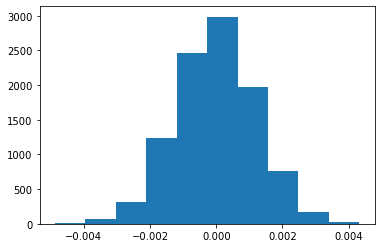

In [55]:
plt.hist(p_diffs);

As expected, the plot shows that the sampling distribution of the differences `p_diffs`, is normally distributed.

<br>

#### P-value
To get the p-value, I'll find the proportion of difference values in `p_diffs` that are equal to, or more extreme than (i.e. in favour of the alternative) the actual difference observed from the original data. This would mean differences which are greater than (in accordance with the null hypothesis) the observed difference.

**NB:** The observed difference is the conversion rate for both the old and new pages as observed from the data.

In [56]:
# get observed difference first, then determine the more extreme values in favour of the alternative
obs_diff = (df2[df2.group=='treatment'].converted.mean()) - (df2[df2.group=='control'].converted.mean())
p_val = (p_diffs > obs_diff).mean()
p_val

0.9058

Above, I've computed the probability of obtaining our observed statistic, `obs_diff`, or a more extreme value (in favour of the alternative hypothesis) based on the premise that the null hypothesis is true. This probability is the **p-value** for the sampling distribution of differences.

Since this value is greater than the our designated significance level of **alpha=0.05**, then we may conclude that, based on the data, we do not have sufficient evidence in favour of the alternative hypothesis, hence, the result is not statistically significant and we do not reject the null hypothesis. In other words, the difference between the conversion rate for the old page and that of the new page is less than or equal to `0`, or otherwise put: **the conversion rate for the old page is either greater than or equal to that of the new page.**

I would like to also make use of a built-in to ensure I achieve similar results.

I'll be making use of the `statsmodels` library in Python, and the same parameters as before.

In [57]:
import statsmodels.api as sm

convert_old = df2[df2.landing_page=='old_page'].converted.sum()
convert_new = df2[df2.landing_page=='new_page'].converted.sum()
n_old = df2[df2.landing_page=='old_page'].shape[0]
n_new = df2[df2.landing_page=='new_page'].shape[0]

Now, to compute the test statistic (z-score) and the p-value, I'll use the `stats.proportions_ztest` method.

In [59]:
test_stat, p_value = sm.stats.proportions_ztest(np.array([convert_old, convert_new]), np.array([n_old, n_new]), alternative='smaller')
print(f"z-score: {test_stat}\np-value: {p_value}") # test_stat is the z-score for our p-value

z-score: 1.3109241984234394
p-value: 0.9050583127590245


The z-score and p-value obtained above imply that there is no statistical evidence to support the change in the webpage, since there is no increase in the conversion rate for the new page (i.e. both pages have similar conversion rates, or old is greater than new) according to the data.

Indeed, these results are in agreement with the findings from the simulated distributions.

<a id='regression'></a>
#### A regression approach

In this final part, I will be using regression in order to, hopefully, achieve similar results as in the previous methods.

A logistic regression would be the appropriate kind of regression in this case, as it involves the determination of which category a given dataset falls into (i.e. conversion or no conversion).

The goal here is to use `statsmodels` to fit a logistic regression model to see if there is a significant difference in conversion as a consequence of which page a customer receives.

To use `statsmodels`, I'll first need to create a column for the intercept, and create a dummy variable column for which page each user received.

In essence, I'll add an `intercept` column with all `1`'s, as well as an `ab_page` column, which is 1 when an individual receives the new page (**treatment**) and 0 if they recieved the the old page(**control**).

In [60]:
df2['intercept'] = 1
df2['ab_page'] = pd.get_dummies(df2.group)['treatment']
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


Instantiate the model, and fit the model using the two columns earlier created to predict whether or not an individual converts.

In [61]:
log_mod_1 = sm.Logit(df2.converted, df2[['intercept', 'ab_page']])
result_1 = log_mod_1.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


##### Model summary

In [136]:
result_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Thu, 16 Jul 2020   Pseudo R-squ.:               8.077e-06
Time:                        17:43:47   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

From the regression summary above, the p-value associated with the **ab_page** variable is `0.190`. This value differs from the p-value obtained using A/B testing, which is as a result of the difference in how the hypotheses were set up.

In the A/B testing scenario, I used a `one-tailed test`: we were interested in an observed change in just one direction away from our metric i.e.

$H_{o}$: $p_{new}$ - $p_{old}$ $\leq$ 0,

$H_{1}$: $p_{new}$ - $p_{old}$ $\gt$ 0;

whereas, in the regression case above, I make use of a `two-tailed test`: we are concerned with a change in either direction of the metric being measured i.e.

$H_{o}$: $p_{new}$ - $p_{old}$ = 0,

$H_{1}$: $p_{new}$ - $p_{old}$ $\neq$ 0).

Now, I am considering adding other variables that might influence whether or not an individual converts. Would this be a good idea?

From the summary table above, the independent variable, `ab_page`, has a p-value of `0.190`, which implies that the variable is not statistically significant (since p>$\alpha$). This means that there is no observable change in the conversion rate that may be as a consequence of a change in the webpage that a user is shown. As a result, it would make sense to consider other factors that might influence a change in the conversion rate. Also, from the `McFadden pseudo-R squared` value in the summary, it is quite clear that the `ab_page` feature accounts for a very meager amount(practically zero) of the variability in the dependent variable (i.e. the conversion rate), hence, the need to explore other variables for better explainability.

The effect of inserting an additional feature into the model would depend partly (among other factors) on whether the variable is correlated with any of the already existing features, and/or with the response variable. In a case where there is a correlation, the added variable would definitely have a negative effect on the overall quality of the model. In the alternate scenario in which absolutely no correlation is present (which never really happens in practice: we generally decide on what level of collinearity is tolerable), then the additional variable contributes positively to the explainability of the model.

So, in the quest for better explainability, I'll be adding a new feature: **the country in which a user lives**. I'll read in the **countries.csv** dataset and merge it to the original dataset on the `user_id`. Again I'll create dummy variables for the `country` column. Let's find out if this added variable is a better predictor of conversion rate.So, in the quest for better explainability, I'll be adding a new feature: **the country in which a user lives**. I'll read in the **countries.csv** dataset and merge it to the original dataset on the `user_id`. Again I'll create dummy variables for the `country` column. Let's find out if this added variable is a better predictor of conversion rate.

In [63]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [64]:
# check unique entries in 'country' column
df_new.country.unique()

array(['UK', 'US', 'CA'], dtype=object)

In [65]:
### Create the necessary dummy variables.
### I'll create dummies for UK and US alone, leaving CA as the baseline.
df_new[['UK', 'US']] = pd.get_dummies(df_new.country)[['UK','US']]

log_mod_2 = sm.Logit(df_new.converted, df_new[['intercept', 'ab_page', 'UK', 'US']])
result_2 = log_mod_2.fit()
# get model summary
result_2.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Mon, 03 Aug 2020   Pseudo R-squ.:               2.323e-05
Time:                        19:46:43   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
UK             0.0506      0.028      1.784      0.074      -0.005       0.106
US             0.0408      0.027      1.516      0.130      -0.012       0.093
==============================================================================
"""

From the summary above, we see that the p-values for both UK and US (`0.074` and `0.130` respectively) are less than the chosen $\alpha$-value of 0.05 and are thus not significant covariates of the model. Also, the pseudo R-squared value (though not a good estimate of explainability) indicates that the  added country variables did not substantially contribute to the explainability of the model. In sum, the `country` variable does not seem to have any impact on conversion.

I have now looked at the individual factors of **country** and **page** on conversion. I would now like to look at an interaction between page and country to see if that would have a significant effect on conversion.

In [66]:
# create the additional columns for the interactions
df_new['UK_ab_page'] = df_new['UK'] * df_new['ab_page']
df_new['US_ab_page'] = df_new['US'] * df_new['ab_page']

In [67]:
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,UK,US,UK_ab_page,US_ab_page
user_id,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,1,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,1,0,1,0


In [68]:
### Fit the Linear Model And Obtain the Results
log_mod_3 = sm.Logit(df_new.converted, df_new[['intercept','ab_page', 'UK', 'US', 'UK_ab_page', 'US_ab_page']])
result_3 = log_mod_3.fit()
result_3.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Mon, 03 Aug 2020   Pseudo R-squ.:               3.482e-05
Time:                        19:57:50   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0040      0.036    -55.008      0.000      -2.075      -1.933
ab_page       -0.0674      0.052     -1.297      0.195      -0.169       0.034
UK             0.0118      0.040      0.296      0.767      -0.066       0.090
US             0.0175      0.038      0.465      0.642      -0.056       0.091
UK_ab_page     0.0783      0.057      1.378      0.168      -0.033       0.190
US_ab_page     0.0469      0.054      0.872      0.383      -0.059       0.152
==============================================================================
"""

###### Conclusions
* From the summary above, the interactions between the page shown to a user and the country that user comes from does not influence the conversion of the user. This is because the p-values for the interaction variables with respect to the dependent variable are all $\gt \alpha$ (0.05), meaning they are not statistically significant.
* Practically speaking, the country from which a user visits a webpage is a large categorisation, and, hence, isn't likely to have much predictive power on its own, except perhaps more related information is given (like government policy vis-a-vis the web, internet censorship, etc).
* In sum, statistically speaking, the webpage, country, and the interaction between both of these variables, do not appear to have any impact on the conversion of users.

#### Recommendation

Based on all the evidence from the A/B test and logistic regression, there is no evidence that the new page would improve the conversion rate of the e-commerce company. In that light, I would recommend that the company choose to stick to the old page for the mean time, while researching on website features that would positively influence the chosen metric, and then another A/B test could be run to measure that influence.

###### References
* https://www.intechopen.com/books/bayesian-inference/bayesian-hypothesis-testing-an-alternative-to-null-hypothesis-significance-testing-nhst-in-psycholog
* http://www.real-statistics.com/hypothesis-testing/null-hypothesis/
* https://stats.stackexchange.com/questions/52067/does-adding-more-variables-into-a-multivariable-regression-change-coefficients-o
* https://thestatsgeek.com/2014/02/08/r-squared-in-logistic-regression/
* https://www.pluralsight.com/guides/interpreting-data-using-statistical-models-python
* https://www.displayr.com/how-to-interpret-logistic-regression-coefficients/